# Introduction to Particle Filtering

Particle filtering (also known as the Sequential Monte Carlo method) is a powerful technique used in state estimation for nonlinear and non-Gaussian dynamic systems. It's particularly useful when you need to estimate the state of a system over time using noisy and indirect observations.

It can be seen as a "brute-force" way to estimate the system state, based on running many parallel simulations.

## **Why is the Particle Filter Called a "Filter"?**

The **particle filter** is called a **filter** because it is used to estimate the hidden (latent) state of a **dynamic system** over time, given noisy observations. The term "filtering" comes from **Bayesian filtering**, which refers to the process of continuously updating our belief about the system's state as new measurements arrive.

### **Formulating the Filtering Problem**
The **goal** of filtering is to estimate the **hidden state** $ x_t $ of a system at time $ t $, given a sequence of noisy observations $ z_{1:t} $. 

A filtering problem is typically formulated using a **state-space model** consisting of:

1. **State Transition Model** (How the system evolves):  
   $$
   x_t = f(x_{t-1}, v_t)
   $$
   - $ x_t $ is the state at time $ t $.
   - $ f(\cdot) $ is the transition function (possibly nonlinear).
   - $ v_t $ is the **process noise**.

2. **Observation Model** (How we observe the system):  
   $$
   z_t = h(x_t, w_t)
   $$
   - $ z_t $ is the measurement at time $ t $.
   - $ h(\cdot) $ is the observation function (possibly nonlinear).
   - $ w_t $ is the **measurement noise**.

Given the sequence of measurements $ z_{1:t} $, we aim to compute the **posterior distribution** of the state $ x_t $:

$$
p(x_t \mid z_{1:t})
$$

### **How the Particle Filter Solves This**
The particle filter **approximates** the distribution $ p(x_t \mid z_{1:t}) $ using a set of weighted samples (particles), instead of using an analytical solution (which may be intractable).

- Instead of storing a probability distribution, we use **particles** $ \{x_t^i\} $ with **weights** $ w_t^i $.
- The filtering process involves:
  - **Propagating** particles using the transition model.
  - **Reweighting** particles using the likelihood of observations.
  - **Resampling** to discard unlikely particles and focus on probable ones.

## Why Use Particle Filtering?
- When systems are nonlinear, traditional methods like the **Kalman filter** (which assumes linearity) don't work well.
- When noise is non-Gaussian, the **Extended Kalman Filter (EKF)** and **Unscented Kalman Filter (UKF)** may not perform well.
- Particle filtering can handle arbitrary distributions and complex system models.
- Easy to incorporate extra knowledge of the system process.

## Downsides of Particle Filtering

- It's a brute-force technique: more accuracy requires more computational power.
- Analysis is complex. If you need to provide guarantees, you need a bachelor in statistics or something to that effect.

## How Does It Work?

The main idea is to represent the probability distribution of a system's state using a **set of particles** (samples). These particles approximate the **posterior distribution** of the state given the observations. We use the model of the system dynamics to oudpate each particle, and do a selection of the particles that are performing best according to the observations we get from the system.

## Steps in a Particle Filter:

### 1. **Initialization:** 
- Generate $ N $ particles, each representing a possible system state.
- Assign each particle an initial weight (often uniform, but if you have knowledge of the state, use it here).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Number of particles
N = 5

# True state (we don't know this in real applications)
true_position = 0
true_velocity = 1  # Constant velocity

# Initialize particles
particles = np.random.uniform(-1, 1, N)  # Random positions
weights = np.ones(N) / N  # Uniform weights

# Print particles and weights
print('Particles:', particles)
print('Weights:', weights)


Particles: [ 0.41480928  0.66711074 -0.60815842  0.76428576  0.32230685]
Weights: [0.2 0.2 0.2 0.2 0.2]


### 2. **Prediction (Propagation):**
- Evolve each particle using the **state transition model**.
- This step incorporates process noise and observation noise.

In [2]:
# Noise standard deviations
motion_noise_std = 0.1

# Move true object
true_position += true_velocity + np.random.randn() * motion_noise_std  # True motion

print('True position:', true_position)

True position: 0.908299360875496


In [3]:
# Predict (Move particles according to motion model)
particles += true_velocity + np.random.randn(N) * motion_noise_std
particles

array([1.27637328, 1.68335117, 0.39449564, 1.79666379, 1.14356738])

Compare the position of each particle with the true position above and note that some particles are closer to the real position than others.

### 3. **Update (Weighting):**
- Compute the likelihood of each particle given the new observation.
- Reweight the particles based on how well they match the observation.
   -  The idea is that particles that have been "luckier" in guessing the observation value are given more weight. We could simply define the weights based on the differences between the particle positions and the observation, but this poses several issues: it neglects the standard deviations of the observation standard deviation (intuitively, larger standard deviation of the noise should make it less significant that particles end up further away from the observation); negative differences count the same as positive differences. So we use a smarter update equation below. 

In [4]:
# Observation noise standard deviation
observation_noise_std = 0.1

# Obtain noisy observation
observation = true_position + np.random.randn() * observation_noise_std
print('Observation data of the true position', observation) # This matches something obtained from a sensor, for example

Observation data of the true position 0.8497240769257975


In [5]:
# Update weights based on observation likelihood
weights = np.exp(-0.5 * ((particles - observation) / observation_noise_std) ** 2)
weights += 1e-300  # Avoid zero weights, just for numerical stability
weights /= np.sum(weights)  # Normalize: turn the weights into a probability distribution

weights

array([8.27135661e-03, 6.02553116e-14, 2.34580608e-03, 2.50505527e-18,
       9.89382837e-01])

Note how some weights are higher than others, reflecting the best particles above:

In [6]:
# Get the index of the particle with the highest weight
max_weight_index = np.argmax(weights)
print(f'Particle with index {max_weight_index} has the highest weight estimating the position at: ', particles[max_weight_index])
print('Observation:', observation)
print('True position:', true_position)


Particle with index 4 has the highest weight estimating the position at:  1.1435673831296953
Observation: 0.8497240769257975
True position: 0.908299360875496


Let's break down the update code above:

   1. **Difference between particles and observation:**  
      $$
      (particles - observation)
      $$
      This computes how far each particle's position is from the observed position.

   2. **Standardize by the noise standard deviation:**  
      $$
      \frac{(particles - observation)}{\text{observation\_noise\_std}}
      $$
      This step normalizes the difference so that it is expressed in terms of the noise scale. If the noise is large, small differences are less significant.

   3. **Square the result:**  
      $$
      \left( \frac{(particles - observation)}{\text{observation\_noise\_std}} \right)^2
      $$
      Squaring ensures that differences in both directions (above or below the observed value) contribute positively.

   4. **Multiply by -0.5:**  
      $$
      -0.5 \times \left( \frac{(particles - observation)}{\text{observation\_noise\_std}} \right)^2
      $$
      This is part of the **Gaussian function**, which follows the form:
      $$
      \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
      $$
      Here, $\mu = \text{observation}$ and $\sigma = \text{observation\_noise\_std}$.

   5. **Apply the exponential function:**  
      ```python
      np.exp(...)
      ```
      This converts the squared difference into a likelihood score. **Particles closer to the observation get a higher weight, while those further away get a lower weight.**

   6. **Normalization**:
      After computing the weights, we normalize them so they sum to 1:
      ```python
      weights /= np.sum(weights)
      ```
      This ensures they can be used as **probabilities** in the resampling step.


   **Why Use This Formula?**
   - It ensures that **particles near the observation are given higher weights**.
   - It models **Gaussian measurement noise**, meaning our observations are assumed to follow a normal distribution around the true value.
   - The function **preserves relative probabilities**, so when we normalize later, the most probable particles contribute more.


### 4. **Resampling:**
   - Particles with high weights are duplicated.
   - Particles with low weights are discarded.
   - This step prevents particle **degeneracy** (where a few particles dominate).

In [7]:
# Select particles that remain. We're drawing N samples of the random choice function that selects at random indexes of particles (0...N), but since we're passing the probability distribution of each choice, the particles with higher weights will be selected more often.
indices = np.random.choice(np.arange(N), size=N, p=weights)
print("N particles that will remain: ", indices)

N particles that will remain:  [4 4 4 4 4]


In [8]:
print('Particles before selection:', particles)
particles = particles[indices]
print('Particles after selection:', particles)

Particles before selection: [1.27637328 1.68335117 0.39449564 1.79666379 1.14356738]
Particles after selection: [1.14356738 1.14356738 1.14356738 1.14356738 1.14356738]


### 5. **Repeat:** 
- Store the estimated system state (mean of selected particles).
- Reset the weights, and 
- repeat the above steps, as each new observation of the system arrives.

In [9]:
weights = np.ones(N) / N  # Reset weights so every particle is now equally likely
print('Weights:', weights)

Weights: [0.2 0.2 0.2 0.2 0.2]


In [10]:
# Store estimated position (mean of particles)
estimated_position = np.mean(particles)
print('Estimated position:', estimated_position)
# Get standard deviation of particles. Good to give a notion of uncertainty.
std = np.std(particles)
print('Standard deviation:', std)

Estimated position: 1.1435673831296953
Standard deviation: 0.0


## Putting it all together

The following code puts the above calculation together in a practical example.

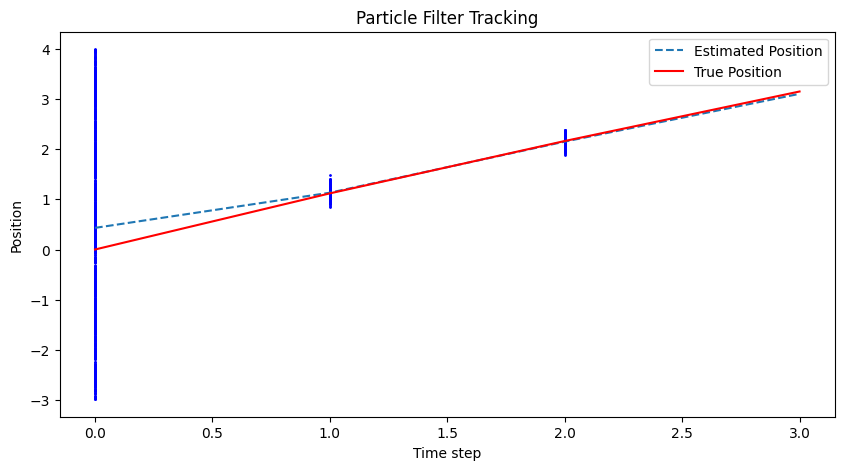

In [11]:
# Number of particles
N = 1000

# True state (we don't know this in real applications)
true_position = 0
true_velocity = 1  # Constant velocity

# Noise standard deviations
motion_noise_std = 0.1
observation_noise_std = 0.1

# Initialize particles
particles = np.random.uniform(-3, 4, N)  # Random positions. Change to try out different initializations
weights = np.ones(N) / N  # Uniform weights

# Simulation parameters
num_steps = 3  # Time steps

# Store results
positions = [np.mean(particles)]  # Store estimated positions
true_positions = [true_position]  # Store true positions
particle_positions = [np.copy(particles)]  # Store particle positions

# Particle Filter Loop
for t in range(num_steps):
    # Move true object
    true_position += true_velocity + np.random.randn() * motion_noise_std  # True motion
    true_positions.append(true_position)

    # Simulate noisy observation
    observation = true_position + np.random.randn() * observation_noise_std
    
    # 1. Predict (Move particles according to motion model)
    particles += true_velocity + np.random.randn(N) * motion_noise_std
    
    # 2. Update weights based on observation likelihood
    weights = np.exp(-0.5 * ((particles - observation) / observation_noise_std) ** 2)
    weights += 1e-300  # Avoid zero weights
    weights /= np.sum(weights)  # Normalize
    
    # 3. Resample: Select particles based on their weights
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    particles = particles[indices]
    weights = np.ones(N) / N  # Reset weights
    
    assert len(particles) == N

    # Store particle positions
    particle_positions.append(np.copy(particles))

    # Store estimated position (mean of particles)
    estimated_position = np.mean(particles)
    positions.append(estimated_position)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(num_steps+1), positions, label="Estimated Position", linestyle="dashed")
plt.plot(range(num_steps+1), true_positions, label="True Position", color='r')

# Plot particles
for t in range(num_steps):
    plt.scatter([t] * N, particle_positions[t], color='b', s=1)
    
plt.xlabel("Time step")
plt.ylabel("Position")
plt.legend()
plt.title("Particle Filter Tracking")
plt.show()

## Revisiting previous notebook car example

We now extend the previous notebook's example by implementing a Particle Filter to correct the car’s estimated position based on noisy GPS measurements.

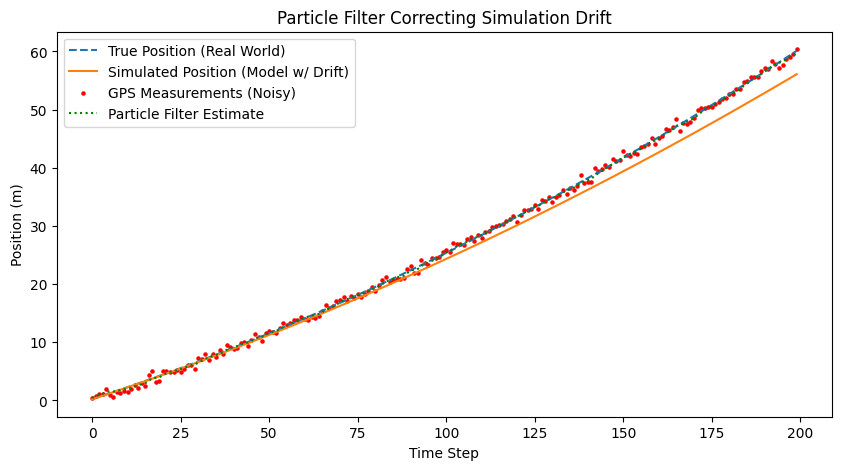

In [12]:
# Time step and duration
dt = 0.1  # Time step (s)
T = 20  # Total simulation time (s)
steps = int(T / dt)

# True car dynamics (real-world)
true_x = 0  # Initial position
true_v = 2  # True velocity (m/s)
true_a = 0.1  # True acceleration (m/s^2)

# Simulated car dynamics (imperfect model)
sim_x = 0
sim_v = 2
sim_a = 0.08  # Slightly incorrect acceleration

# Measurement noise parameters (GPS-like noise)
gps_noise_std = 0.5  # Standard deviation (m)

# Particle filter parameters
num_particles = 1000
particles = np.random.normal(0, 1, num_particles)  # Initialize particles around 0
weights = np.ones(num_particles) / num_particles  # Uniform weights

# Lists to store results
true_positions = []
sim_positions = []
gps_measurements = []
pf_estimates = []  # Particle filter estimated positions

# Particle Filter Process
for _ in range(steps):
    # --- True Motion (Real World) ---
    true_v += true_a * dt
    true_x += true_v * dt

    # --- Simulated Motion (Model with Drift) ---
    sim_v += sim_a * dt
    sim_x += sim_v * dt

    # --- GPS Measurement (with Noise) ---
    gps_x = true_x + np.random.normal(0, gps_noise_std)

    # --- Particle Filter Update ---
    # 1. Motion Update: Move particles forward using a motion model (with noise)
    particles += sim_v * dt + np.random.normal(0, 0.1, num_particles)

    # 2. Measurement Update: Compute weights based on GPS measurement
    weights = np.exp(-0.5 * ((particles - gps_x) / gps_noise_std) ** 2)
    weights += 1e-300  # Avoid zeros
    weights /= np.sum(weights)  # Normalize weights

    # 3. Resampling: Draw new particles based on weights
    indices = np.random.choice(range(num_particles), size=num_particles, p=weights)
    particles = particles[indices]

    # Store estimated position as the mean of particles
    pf_estimate = np.mean(particles)

    # Store values
    true_positions.append(true_x)
    sim_positions.append(sim_x)
    gps_measurements.append(gps_x)
    pf_estimates.append(pf_estimate)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(true_positions, label="True Position (Real World)", linestyle='dashed')
plt.plot(sim_positions, label="Simulated Position (Model w/ Drift)", linestyle='solid')
plt.scatter(range(len(gps_measurements)), gps_measurements, label="GPS Measurements (Noisy)", color='red', s=5)
plt.plot(pf_estimates, label="Particle Filter Estimate", linestyle='dotted', color='green')
plt.xlabel("Time Step")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Particle Filter Correcting Simulation Drift")
plt.show()

## Higher Dimensions and Python Library for Particle Filtering

This example was taken from https://pypfilt.readthedocs.io/en/latest/index.html 

Read that tutorial for more examples.

### The Lorenz-63 system

The [Lorenz-63 system](https://en.wikipedia.org/wiki/Lorenz_system) is a system of ordinary differential equations that has chaotic solutions for some parameter values and initial states.

$$
   \frac{dx}{dt} = \sigma (y - x) \\
   \frac{dy}{dt} = x (\rho - z) - y \\
   \frac{dz}{dt} = xy - \beta z \\
$$

where x, y, and z, are states of the system, and the other terms are parameters.

In [13]:
%pip install pypfilt[plot]

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pypfilt import OdeModel

class Lorenz63(OdeModel):
    def field_types(self, ctx):
        r"""
        Define the state vector :math:`[\sigma, \rho, \beta, x, y, z]^T`.
        """
        return [
            ('sigma', float),
            ('rho', float),
            ('beta', float),
            ('x', float),
            ('y', float),
            ('z', float),
        ]

    def d_dt(self, time, xt, ctx, is_forecast):
        """
        The right-hand side of the ODE system.

        :param time: The current time.
        :param xt: The particle state vectors.
        :param ctx: The simulation context.
        :param is_forecast: True if this is a forecasting simulation.
        """
        rates = np.zeros(xt.shape, xt.dtype)
        rates['x'] = xt['sigma'] * (xt['y'] - xt['x'])
        rates['y'] = xt['x'] * (xt['rho'] - xt['z']) - xt['y']
        rates['z'] = xt['x'] * xt['y'] - xt['beta'] * xt['z']
        return rates


The code above makes the parameters looks like states by giving then a time derivative of zero. So the system is equivalent to:

$$
   \frac{dx}{dt} = \sigma (y - x) \\
   \frac{dy}{dt} = x (\rho - z) - y \\
   \frac{dz}{dt} = xy - \beta z \\
   \frac{d\sigma}{dt} = 0 \\
   \frac{d\rho}{dt} = 0 \\
   \frac{d\beta}{dt} = 0 \\
$$

This is equivalent to the previous system.

### Observation Model

To define the relationship between the Lorenz-63 simulation model and observations of this system, we need to define an **observation model**.

When the observation model can be described using a standard probability distribution, we only need to create a `pypfilt.obs.Univariate` subclass that returns a SciPy distribution <https://docs.scipy.org/doc/scipy/reference/stats.html> for the given state vectors $\mathbf{x_t}$.

For simplicity, we assume that $x(t)$, $y(t)$, and $z(t)$ can be directly observed (define the observed values as $X_t$, $Y_t$, and $Z_t$, respectively) and that the observation error is distributed normally with zero mean and standard deviation $\sigma = 1.5$:

$$
   X_t \sim \mathcal{N}(\mu = x(t), \sigma = 1.5) \\
   Y_t \sim \mathcal{N}(\mu = y(t), \sigma = 1.5) \\
   Z_t \sim \mathcal{N}(\mu = z(t), \sigma = 1.5)
$$

The implementation of these observation models is straightforward, and comprises two steps.
First, extract the expected value for each particle from the state vectors, then construct a corresponding normal distribution for each particle:


In [15]:
from pypfilt.obs import Univariate
import scipy.stats

class ObsLorenz63(Univariate):

    def distribution(self, ctx, snapshot):
        expect = snapshot.state_vec[self.unit]
        return scipy.stats.norm(loc=expect, scale=1.5)


**Note:** `pypfilt` supports multiple observation models.
Each observation model is associated with a unique identifier (an **"observation unit"**) that is used to identify the observations related to this model.
Here, we use the observation unit (`self.unit`) to identify the field in the state vector that is being observed (see the highlighted line, above).
This allows us to use three instances of the `pypfilt.examples.lorenz.ObsLorenz63` class to observe $x(t)$, $y(t)$, and $z(t)$.

We could define an observation model specifically for $x(t)$ (which is named `x` in the state vector) by replacing the line above with:

``python
expect = snapshot.state_vec['x']
``

## Defining a scenario

Scenarios are defined in TOML files, as illustrated in the example below.

- The key components are defined in the `[components]` table:
    - The simulation model (`model`);
    - The time scale (`time`, either `scalar time <pypfilt.time.Scalar>` or `date-time <pypfilt.time.Datetime>`);
    - The prior distribution sampler (`sampler`); and
    - The output recorder (`summary`).
- The simulation period and time-step settings are defined in the `[time]` table.
- The model prior distribution is defined in the `[prior]` table.
   Here, we have defined all the parameters and state variables to have **fixed values**, so that we can simulate observations from a known ground truth.
- Each observation model is defined in an `[observations.UNIT]` table, where `UNIT` is the **observation unit** (see :ref:`lorenz63-obs` for details).
   Here, we have defined three observations models, with observation units `'x'`, `'y'`, and `'z'`.
- Particle filter settings are defined in the `[filter]` table, including:
    - The number of particles (`particles`); and
    - The seed for the pseudo-random number generator (`prng_seed`).
- Each scenario is defined in a `[scenario.ID]` table, where `ID` is a unique identifier for the scenario.

In [16]:
%%writefile lorenz63_simulate.toml

[components]
model = "pypfilt.examples.lorenz.Lorenz63"
time = "pypfilt.Scalar"
sampler = "pypfilt.sampler.LatinHypercube"
summary = "pypfilt.summary.HDF5"

[time]
start = 0.0
until = 25.0
steps_per_unit = 10
summaries_per_unit = 10

[prior]
sigma = { name = "constant", args.value = 10 }
rho = { name = "constant", args.value = 28 }
beta = { name = "constant", args.value = 2.66667 }
x = { name = "constant", args.value = 1 }
y = { name = "constant", args.value = 1 }
z = { name = "constant", args.value = 1 }

[observations.x]
model = "pypfilt.examples.lorenz.ObsLorenz63"

[observations.y]
model = "pypfilt.examples.lorenz.ObsLorenz63"

[observations.z]
model = "pypfilt.examples.lorenz.ObsLorenz63"

[filter]
particles = 500
prng_seed = 2001
history_window = -1
resample.threshold = 0.25

[scenario.simulate]

Overwriting lorenz63_simulate.toml


Once we have defined one or more scenarios in a TOML file, we can iterate over the scenario instances with `pypfilt.load_instances`:

In [17]:
"""Ensure that the example Lorenz-63 file defines a single scenario."""
import pypfilt

scenario_file = 'lorenz63_simulate.toml'
instances = list(pypfilt.load_instances(scenario_file))
assert len(instances) == 1
instance = instances[0]
instance

Instance(scenario_id="simulate", descriptor="")

## Simulating observations

Once a scenario has been defined, we can simulate observations from each observation model with:

In [18]:
# Simulate observations for x(t), y(t), and z(t).
obs_tables = pypfilt.simulate_from_model(instance)
obs_tables

{'x': array([( 0. ,  2.06070899e+00), ( 0.1,  3.01188630e+00),
        ( 0.2,  6.56829063e+00), ( 0.3,  1.85265495e+01),
        ( 0.4,  1.65133082e+01), ( 0.5,  1.67653103e+00),
        ( 0.6, -4.95753096e+00), ( 0.7, -9.22904183e+00),
        ( 0.8, -8.05504235e+00), ( 0.9, -1.04351456e+01),
        ( 1. , -1.09116640e+01), ( 1.1, -8.04035914e+00),
        ( 1.2, -6.57836886e+00), ( 1.3, -7.85641322e+00),
        ( 1.4, -8.81366981e+00), ( 1.5, -8.55125244e+00),
        ( 1.6, -1.10445712e+01), ( 1.7, -9.52424056e+00),
        ( 1.8, -7.44405712e+00), ( 1.9, -4.48718303e+00),
        ( 2. , -9.16302455e+00), ( 2.1, -1.15700675e+01),
        ( 2.2, -1.04848883e+01), ( 2.3, -9.02173309e+00),
        ( 2.4, -5.94611108e+00), ( 2.5, -7.97915983e+00),
        ( 2.6, -1.00262301e+01), ( 2.7, -1.11005899e+01),
        ( 2.8, -1.04436597e+01), ( 2.9, -8.65341224e+00),
        ( 3. , -8.22168326e+00), ( 3.1, -6.84182811e+00),
        ( 3.2, -8.39315713e+00), ( 3.3, -8.58756053e+00),
        (

In [19]:
obs_tables['x']

array([( 0. ,  2.06070899e+00), ( 0.1,  3.01188630e+00),
       ( 0.2,  6.56829063e+00), ( 0.3,  1.85265495e+01),
       ( 0.4,  1.65133082e+01), ( 0.5,  1.67653103e+00),
       ( 0.6, -4.95753096e+00), ( 0.7, -9.22904183e+00),
       ( 0.8, -8.05504235e+00), ( 0.9, -1.04351456e+01),
       ( 1. , -1.09116640e+01), ( 1.1, -8.04035914e+00),
       ( 1.2, -6.57836886e+00), ( 1.3, -7.85641322e+00),
       ( 1.4, -8.81366981e+00), ( 1.5, -8.55125244e+00),
       ( 1.6, -1.10445712e+01), ( 1.7, -9.52424056e+00),
       ( 1.8, -7.44405712e+00), ( 1.9, -4.48718303e+00),
       ( 2. , -9.16302455e+00), ( 2.1, -1.15700675e+01),
       ( 2.2, -1.04848883e+01), ( 2.3, -9.02173309e+00),
       ( 2.4, -5.94611108e+00), ( 2.5, -7.97915983e+00),
       ( 2.6, -1.00262301e+01), ( 2.7, -1.11005899e+01),
       ( 2.8, -1.04436597e+01), ( 2.9, -8.65341224e+00),
       ( 3. , -8.22168326e+00), ( 3.1, -6.84182811e+00),
       ( 3.2, -8.39315713e+00), ( 3.3, -8.58756053e+00),
       ( 3.4, -9.60781165e+00),

In [20]:
# Save the observations to plain-text files.
for obs_unit, obs_table in obs_tables.items():
    out_file = f'lorenz63-{obs_unit}.ssv'
    pypfilt.io.write_table(out_file, obs_table)

## Running forecasts

In order to fit the simulation model to observations and generate forecasts, we need to:
1. Choose prior distributions for $x(t)$, $y(t)$, and $z(t)$;
2. Define an input file for each observation model; and
3. Record summary statistics such as `predictive credible intervals <pypfilt.summary.PredictiveCIs>` for each observation model, and `simulated observations <pypfilt.summary.SimulatedObs>` for $z(t)$.

These modified scenario is as follows:

In [21]:
%%writefile lorenz63_forecast.toml
[components]
model = "pypfilt.examples.lorenz.Lorenz63"
time = "pypfilt.Scalar"
sampler = "pypfilt.sampler.LatinHypercube"
summary = "pypfilt.summary.HDF5"

[time]
start = 0.0
until = 25.0
steps_per_unit = 10
summaries_per_unit = 10

[prior]
sigma = { name = "constant", args.value = 10 }
rho = { name = "constant", args.value = 28 }
beta = { name = "constant", args.value = 2.66667 }
x = { name = "uniform", args.loc = -5, args.scale = 10 }
y = { name = "uniform", args.loc = -5, args.scale = 10 }
z = { name = "uniform", args.loc = -5, args.scale = 10 }

[observations.x]
model = "pypfilt.examples.lorenz.ObsLorenz63"
file = "lorenz63-x.ssv"

[observations.y]
model = "pypfilt.examples.lorenz.ObsLorenz63"
file = "lorenz63-y.ssv"

[observations.z]
model = "pypfilt.examples.lorenz.ObsLorenz63"
file = "lorenz63-z.ssv"

[summary.tables]
forecasts.component = "pypfilt.summary.PredictiveCIs"
forecasts.credible_intervals = [50, 60, 70, 80, 90, 95]
sim_z.component = "pypfilt.summary.SimulatedObs"
sim_z.observation_unit = "z"

[filter]
particles = 500
prng_seed = 2001
history_window = -1
resample.threshold = 0.25

[scenario.forecast]

Overwriting lorenz63_forecast.toml


In [22]:
scenario_file = 'lorenz63_forecast.toml'
instances = list(pypfilt.load_instances(scenario_file))
instance = instances[0]

# Run a forecast from t = 20.
forecast_time = 20
context = instance.build_context()
results = pypfilt.forecast(context, [forecast_time], filename='lorenz63_forecast.h5')

[HDF5](http://hdfgroup.org/) is a file format that allows you to store lots of data tables and related metadata in a single file, and to load these data tables as if they were NumPy arrays. All of the summary tables recorded by [pypfilt](https://bitbucket.org/robmoss/particle-filter-for-python) are NumPy [structured arrays](https://numpy.org/doc/stable/user/basics.rec.html). You can explore HDF5 files with the [h5py](https://www.h5py.org/) package, which makes it easy to load and store data tables.

## Plotting the results

The [`pypfilt.plot`](https://pypfilt.readthedocs.io/en/latest/api/plot.html#module-pypfilt.plot "pypfilt.plot") module provides functions for plotting observations and credible intervals, and classes for constructing figures with sub-plots. For example, we can use the [`Wrap`](https://pypfilt.readthedocs.io/en/latest/api/plot.html#pypfilt.plot.Wrap "pypfilt.plot.Wrap") class to plot the simulation model fits and forecasts against the simulated observations for $x(t)$, $y(t)$, and $z(t)$:

In [23]:
import matplotlib

backcast_time = 10
forecast_time = 20

# Collect credible intervals for the recent backcast and the forecast.
fit = results.estimation.tables['forecasts']
forecast = results.forecasts[forecast_time].tables['forecasts']
credible_intervals = np.concatenate(
    (fit[fit['time'] >= backcast_time], forecast)
)

# Collect the simulated observations that were used to fit the model.
backcast_obs = {
    unit: table[
        np.logical_and(
            table['time'] >= backcast_time,
            table['time'] <= forecast_time,
        )
    ]
    for (unit, table) in obs_tables.items()
}

# Collect the simulated observations over the forecast horizon.
future_obs = {
    unit: table[table['time'] > forecast_time]
    for (unit, table) in obs_tables.items()
}

# Plot the backcast and forecast against the simulated observations.
matplotlib.use('Agg')
with pypfilt.plot.apply_style():
    plot = pypfilt.plot.Wrap(
        credible_intervals,
        'Time',
        '',
        ('unit', lambda s: '{}(t)'.format(s)),
        nc=1,
    )

    plot.expand_x_lims('time')
    plot.expand_y_lims('ymax')
    plot.fig.subplots_adjust(hspace=0.5)

    obs_size = 25.0

    for ax, df in plot.subplots():
        # Plot each forecast credible interval.
        hs = pypfilt.plot.cred_ints(ax, df, 'time', 'prob')

        # Plot the observations up to the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                backcast_obs[df['unit'][0]],
                label='Past observations',
                s=obs_size,
            )
        )

        # Plot the observations after the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                future_obs[df['unit'][0]],
                future=True,
                label='Future observations',
                s=obs_size,
            )
        )

        plot.add_to_legend(hs)

        # Add a vertical line to indicate the forecast time.
        ax.axvline(
            x=forecast_time, linestyle='--', color='#7f7f7f', zorder=0
        )

        # Adjust the axis limits and the number of ticks.
        x_range = df['time'].max() - df['time'].min()
        x_expand = x_range * 0.01
        ax.set_xlim(
            left=df['time'].min() - x_expand,
            right=df['time'].max() + x_expand,
        )
        ax.locator_params(axis='x', nbins=6)
        ax.set_ylim(auto=True)
        ax.locator_params(axis='y', nbins=6)

    plot.legend(loc='upper center', ncol=4, borderaxespad=0)

    # NOTE: do not save the matplotlib version in the image metadata.
    # This ensures the images are reproducible across matplotlib versions.
    plot.save(
        "lorenz63_forecast.png",
        format='png',
        width=10,
        height=5,
        metadata={'Software': None},
    )


![](./lorenz63_forecast.png)